In [1]:
import tensorflow as tf 
tf.enable_eager_execution()

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2

In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [4]:
# Using the code from colab example 
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.
test_images /= 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

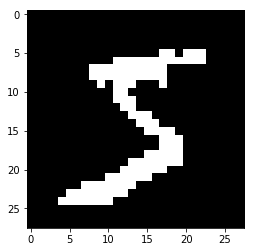

In [5]:
plt.imshow(cv2.cvtColor(train_images[0], cv2.COLOR_GRAY2RGB))

In [6]:
TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [8]:
class VAEMNIST(tf.keras.Model):
    """Same Architecture"""
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.relu),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.relu),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.relu),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME",activation=tf.nn.relu),
            tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.relu),
            tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ])
        
    def sample(self):
        latent = tf.random_normal(shape=(1, self.latent_dim))
        return latent, tf.nn.sigmoid(self.decoder(latent))
        
    def call(self, img, is_sigmoid=False):
        """Reuse the code from the Google Example"""
        mean, log_var = tf.split(self.encoder(img), num_or_size_splits=2, axis=1)
        
        normal = tf.random_normal(shape=mean.shape)
        latent = normal * tf.exp(log_var * .5) + mean
        
        out = self.decoder(latent)
        if is_sigmoid:
            out = tf.nn.sigmoid(out)
        return latent, out, mean, log_var

In [9]:
vae = VAEMNIST(50)

In [11]:
optimizer = tf.train.AdamOptimizer(1e-4)

for epoch in range(2):
    print(f"At epoch {epoch}")
    for i, img in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            tape.watch(vae.variables)

            latent, out, mean, log_var = vae(img)
            
            # Reconstruction loss ? 
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=out, labels=img)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
            
            # KL Loss -- From https://wiseodd.github.io/techblog/2017/01/24/vae-pytorch/
            kl_loss = 0.5 * tf.reduce_sum(tf.exp(log_var) + mean**2 - 1. - log_var, axis=[1])
            
            loss = -tf.reduce_mean(logpx_z - kl_loss)
            
            if i % 100 == 0:
                print(loss)
                
        grad = tape.gradient(loss, vae.variables)
        optimizer.apply_gradients(zip(grad, vae.variables))
    
    print("---------------------")

At epoch 0
tf.Tensor(542.4345, shape=(), dtype=float32)
tf.Tensor(328.52423, shape=(), dtype=float32)
tf.Tensor(229.5795, shape=(), dtype=float32)
tf.Tensor(222.94641, shape=(), dtype=float32)
tf.Tensor(205.85031, shape=(), dtype=float32)
tf.Tensor(191.44226, shape=(), dtype=float32)
---------------------
At epoch 1
tf.Tensor(198.5812, shape=(), dtype=float32)
tf.Tensor(180.69945, shape=(), dtype=float32)
tf.Tensor(181.0602, shape=(), dtype=float32)
tf.Tensor(175.40576, shape=(), dtype=float32)
tf.Tensor(166.91945, shape=(), dtype=float32)
tf.Tensor(160.19772, shape=(), dtype=float32)
---------------------


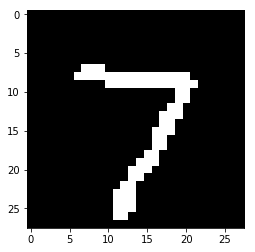

In [12]:
plt.imshow(cv2.cvtColor(test_images[0], cv2.COLOR_GRAY2RGB))

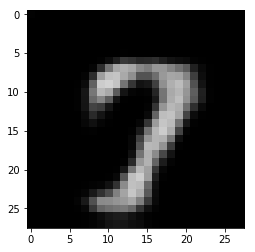

In [13]:
img_tensor = tf.convert_to_tensor(test_images[0])
img_tensor = tf.expand_dims(img_tensor, axis=0)

latent, out, _, _ = vae(img_tensor)
out = tf.squeeze(tf.nn.sigmoid(out), axis=0)

plt.imshow(cv2.cvtColor(out.numpy(), 
    cv2.COLOR_GRAY2RGB
))

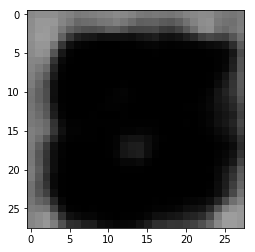

In [14]:
sampled_latent, img = vae.sample()
plt.imshow(cv2.cvtColor(img[0].numpy(), 
    cv2.COLOR_GRAY2RGB
))

In [15]:
diff = latent - sampled_latent
number_steps = 10
diff = diff/number_steps 
diff

<tf.Tensor: id=418410, shape=(1, 50), dtype=float32, numpy=
array([[-0.01950146, -0.01153946, -0.07696985, -0.1519366 , -0.08536483,
         0.1981372 , -0.16983165,  0.18126145, -0.04738343,  0.2243551 ,
        -0.05136085, -0.01949572, -0.09880067,  0.18937893,  0.07335505,
        -0.10379537, -0.04812151, -0.29889166,  0.05378396, -0.09846316,
         0.09161958, -0.24983935,  0.01084056,  0.00647041,  0.05109337,
         0.07048503, -0.01979521, -0.03108519,  0.09708686,  0.16596639,
        -0.04620503, -0.31609696, -0.04809275, -0.04178143,  0.00588294,
        -0.13930103, -0.07395764, -0.03304292,  0.07406825, -0.14837608,
         0.14517505, -0.08293794,  0.1038347 ,  0.0992792 ,  0.03048811,
         0.05051671,  0.10793036,  0.3667037 ,  0.10183962, -0.15932105]],
      dtype=float32)>

In [16]:
def show_images_grid(imgs_, num_images=25):
    """Reuse the Code"""
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()

    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

In [17]:
middle = sampled_latent
frames = []
for i in range(number_steps):
    out = tf.nn.sigmoid(vae.decoder(middle))
    frames.append(cv2.cvtColor(out[0].numpy(), 
        cv2.COLOR_GRAY2RGB))
    plt.show()
    middle += diff

frames = np.stack(frames)
frames.shape

(10, 28, 28, 3)

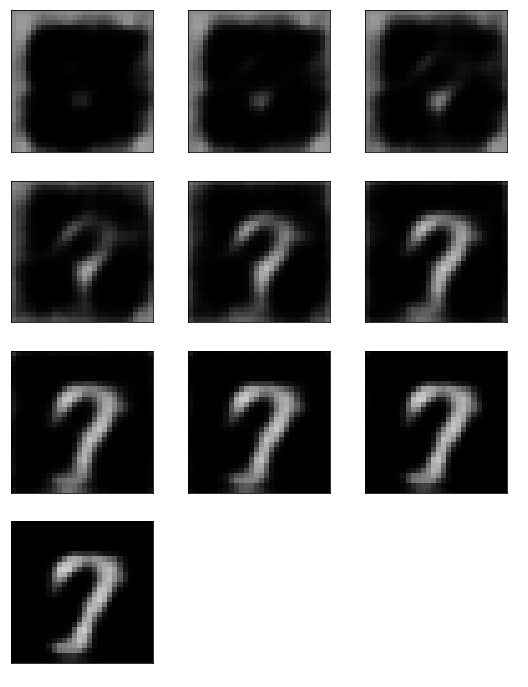

In [18]:
show_images_grid(frames, num_images=10)